<a href="https://colab.research.google.com/github/UEES-IA-Grupo1/multimodal-banking-chatbot-PROJECT/blob/main/Proyecto5_Chatbot_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalación de librerías necesarias
!pip install -q transformers[torch] datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict

# 1. Carga de tu archivo (Sustituye 'tu_archivo.csv' por el nombre real en Colab)
try:
    df = pd.read_csv('conversaciones_reales.csv')
    print("Dataset real cargado con éxito.")
except:
    # Creamos un ejemplo de cómo debería verse si aún no subes el archivo
    print("Archivo no detectado. Creando dataset sintético de banca para demostración...")
    data = {
        "text": [
            "Hola, perdí mi tarjeta Visa esta mañana",
            "¿Cuál es mi saldo actual en la cuenta de ahorros?",
            "Quiero transferir 500 pesos a mi mamá",
            "No reconozco un cargo de 20 dólares en Amazon",
            "¿Cómo puedo activar mi banca móvil?"
        ],
        "label": [0, 1, 2, 3, 4] # 0: perdida, 1: saldo, 2: transferencia, etc.
    }
    df = pd.DataFrame(data)

# Convertimos a formato de Hugging Face
raw_dataset = Dataset.from_pandas(df)
dataset = raw_dataset.train_test_split(test_size=0.2) # Dividir para entrenar y validar

Archivo no detectado. Creando dataset sintético de banca para demostración...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

tokenized_data = dataset.map(tokenize_fn, batched=True)

# Configuramos el modelo con el número de etiquetas de tu dataset real
num_labels = len(df['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import pipeline

# Pipeline de extracción de entidades
ner_executor = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

def extraer_info_clave(texto):
    entidades = ner_executor(texto)
    print(f"\n--- Analizando: '{texto}' ---")
    if not entidades:
        print("No se detectaron entidades específicas.")
    for ent in entidades:
        print(f"Dato encontrado: {ent['word']} | Categoría: {ent['entity_group']}")

# Prueba con una frase real
extraer_info_clave("I need to send 100 dollars to Steve in London")

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu



--- Analizando: 'I need to send 100 dollars to Steve in London' ---
Dato encontrado: Steve | Categoría: PER
Dato encontrado: London | Categoría: LOC


In [ ]:
import pandas as pd
from datasets import Dataset

# Simulamos la carga del archivo TXT
def cargar_txt_conversaciones(nombre_archivo):
    try:
        with open(nombre_archivo, 'r', encoding='utf-8') as f:
            lineas = f.readlines()

        # Filtrar solo mensajes del cliente (asumiendo formato "Cliente: mensaje")
        # Si tu TXT es distinto, ajustaremos esta lógica
        mensajes = [l.split("Cliente:")[1].strip() for l in lineas if "Cliente:" in l]

        return pd.DataFrame({"text": mensajes})
    except FileNotFoundError:
        print("Esperando archivo... Creando datos de prueba.")
        return pd.DataFrame({"text": ["Quiero bloquear mi tarjeta", "Transferir dinero", "Ver mi estado de cuenta"]})

df_conversaciones = cargar_txt_conversaciones('conversaciones.txt')
print(df_conversaciones.head())

Esperando archivo... Creando datos de prueba.
                         text
0  Quiero bloquear mi tarjeta
1           Transferir dinero
2     Ver mi estado de cuenta


In [ ]:
from transformers import pipeline

from transformers import pipeline

# 1. Reconocimiento de Intenciones (Usando un modelo público alternativo)
# Este modelo clasifica texto en categorías generales y de negocios
intent_classifier = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest" # Opcional: "cross-encoder/nli-distilroberta-base"
)

# 2. Extracción de Entidades (NER) - Este modelo es muy estable
entity_extractor = pipeline(
    "ner",
    model="dbmdz/bert-large-cased-finetuned-conll03-english",
    aggregation_strategy="simple"
)

def procesar_consulta(texto):
    # Intentamos predecir la intención
    # Nota: Como es un modelo general, el label será 'positive', 'neutral' o 'negative'
    # Pero para tu proyecto real con el archivo TXT, luego lo entrenaremos con tus etiquetas.
    res_intencion = intent_classifier(texto)
    entidades = entity_extractor(texto)

    print(f"\n--- Resultado del Análisis ---")
    print(f"Texto: '{texto}'")
    print(f"Intención detectada: {res_intencion[0]['label']} (Confianza: {res_intencion[0]['score']:.2f})")

    if entidades:
        for ent in entidades:
            print(f"Entidad: {ent['word']} | Categoría: {ent['entity_group']}")
    else:
        print("Entidades: No se detectaron datos específicos.")

# Prueba con una frase típica
procesar_consulta("I want to send 500 dollars to Alice in London tomorrow")

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



--- Resultado del Análisis ---
Texto: 'I want to send 500 dollars to Alice in London tomorrow'
Intención detectada: neutral (Confianza: 0.72)
Entidad: Alice | Categoría: ORG
Entidad: London | Categoría: LOC


In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# --- PASO A: Simulación de tu archivo TXT ---
contenido_ejemplo = """Cliente: Quiero bloquear mi tarjeta de credito
Cliente: Cual es el saldo de mi cuenta de ahorros
Cliente: Necesito transferir dinero a un amigo
Cliente: Mi tarjeta se perdio en el cajero
Cliente: Ver movimientos de mi cuenta corriente"""

with open("conversaciones_reales.txt", "w") as f:
    f.write(contenido_ejemplo)

# --- PASO B: Carga y Limpieza del TXT ---
def procesar_mi_txt(path):
    with open(path, "r") as f:
        lineas = f.readlines()
    # Limpiamos el texto quitando "Cliente:"
    textos = [l.replace("Cliente:", "").strip() for l in lineas]
    # Asignamos etiquetas temporales para el ejemplo (0: Bloqueo, 1: Saldo, 2: Transferencia)
    labels = [0, 1, 2, 0, 1]
    return pd.DataFrame({"text": textos, "label": labels})

df = procesar_mi_txt("conversaciones_reales.txt")
dataset = Dataset.from_pandas(df)
print("¡TXT procesado y listo para BERT!")

¡TXT procesado y listo para BERT!


In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)

# Cargamos el modelo para clasificar (ejemplo con 3 tipos de intenciones)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

print("Modelo configurado correctamente.")

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo configurado correctamente.


In [ ]:
# Usamos un modelo que no da errores de permisos
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english", aggregation_strategy="simple")

def sistema_nlu_completo(texto_usuario):
    # 1. Detectar Entidades
    entidades = ner_pipeline(texto_usuario)

    # 2. Clasificar Intención (Simulado con el modelo base por ahora)
    # En un paso real, aquí iría: model(texto_usuario)

    print(f"\n--- ANALIZANDO: {texto_usuario} ---")
    if entidades:
        for ent in entidades:
            print(f"-> Entidad encontrada: {ent['word']} ({ent['entity_group']})")
    else:
        print("-> No se encontraron entidades (nombres, lugares, etc.)")

# Prueba el sistema
sistema_nlu_completo("I want to send money to Juan in Madrid")

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



--- ANALIZANDO: I want to send money to Juan in Madrid ---
-> Entidad encontrada: Juan (PER)
-> Entidad encontrada: Madrid (LOC)


In [ ]:
import re

def extraer_datos_bancarios(texto):
    # 1. Buscar montos (ej: $500, 1000 USD, 50.50 euros, 200 pesos)
    patron_dinero = r'(\$?\d+(?:[.,]\d+)?\s?(?:USD|usd|pesos|euros|€|dollars|dólares)?)'
    montos = re.findall(patron_dinero, texto)

    # 2. Buscar posibles números de cuenta (ej: secuencias de 10 a 16 dígitos)
    patron_cuenta = r'\b\d{10,16}\b'
    cuentas = re.findall(patron_cuenta, texto)

    return {
        "montos_detectados": montos,
        "cuentas_detectadas": cuentas
    }

# Prueba la extracción
prueba = "Quiero transferir $1500.50 a la cuenta 123456789012"
print(f"Resultado: {extraer_datos_bancarios(prueba)}")

Resultado: {'montos_detectados': ['$1500.50 ', '123456789012'], 'cuentas_detectadas': ['123456789012']}


In [ ]:
def chatbot_nlu_pro(texto_usuario):
    print(f"\n{'='*40}")
    print(f"ENTRADA: {texto_usuario}")

    # A. Intención (BERT)
    # Usamos el clasificador que definimos antes
    intencion = intent_classifier(texto_usuario)[0]

    # B. Entidades (NER - Personas/Lugares)
    entidades = entity_extractor(texto_usuario)

    # C. Datos Estructurados (Montos/Cuentas)
    datos = extraer_datos_bancarios(texto_usuario)

    # --- MOSTRAR RESULTADOS ---
    print(f"INTENCIÓN: {intencion['label']} ({intencion['score']:.2f}%)")

    if entidades:
        for e in entidades:
            print(f"ENTIDAD: {e['word']} es un/a {e['entity_group']}")

    if datos['montos_detectados']:
        print(f"DINERO: {datos['montos_detectados']}")

    if datos['cuentas_detectadas']:
        print(f"CUENTA: {datos['cuentas_detectadas']}")
    print(f"{'='*40}")

# EJEMPLO DE USO REAL
chatbot_nlu_pro("I want to send 500 dollars to Alice in London to the account 9876543210")


ENTRADA: I want to send 500 dollars to Alice in London to the account 9876543210
INTENCIÓN: neutral (0.83%)
ENTIDAD: Alice es un/a ORG
ENTIDAD: London es un/a LOC
DINERO: ['500 dollars', '9876543210']
CUENTA: ['9876543210']


In [ ]:
def nlu_pipeline_final(texto):
    # 1. Ejecutar Intención
    res_intent = intent_classifier(texto)[0]

    # 2. Ejecutar NER (Personas, Organizaciones, Lugares)
    entidades_ner = entity_extractor(texto)

    # 3. Ejecutar RegEx (Dinero y Cuentas)
    datos_bancarios = extraer_datos_bancarios(texto)

    # --- CONSOLIDACIÓN ---
    nlu_output = {
        "texto_original": texto,
        "intent": res_intent['label'],
        "confidence": round(res_intent['score'], 4),
        "slots": {
            "per": [e['word'] for e in entidades_ner if e['entity_group'] == 'PER'],
            "loc": [e['word'] for e in entidades_ner if e['entity_group'] == 'LOC'],
            "org": [e['word'] for e in entidades_ner if e['entity_group'] == 'ORG'],
            "amounts": datos_bancarios['montos_detectados'],
            "accounts": datos_bancarios['cuentas_detectadas']
        }
    }
    return nlu_output

# Prueba de fuego
resultado = nlu_pipeline_final("I need to send 1200 USD to Maria in Madrid, my account is 001122334455")
import json
print(json.dumps(resultado, indent=2))

{
  "texto_original": "I need to send 1200 USD to Maria in Madrid, my account is 001122334455",
  "intent": "neutral",
  "confidence": 0.8638,
  "slots": {
    "per": [
      "Maria"
    ],
    "loc": [
      "Madrid"
    ],
    "org": [],
    "amounts": [
      "1200 USD",
      "001122334455"
    ],
    "accounts": [
      "001122334455"
    ]
  }
}


In [ ]:
# --- CLASE DE MEMORIA DEL CHAT ---
class DialogueManager:
    def __init__(self):
        # Memoria persistente de la conversación actual
        self.contexto = {
            "intent_actual": None,
            "datos_recolectados": {
                "destinatario": None,
                "monto": None,
                "cuenta": None
            },
            "paso_finalizado": False
        }

    def procesar_paso(self, nlu_output):
        slots = nlu_output['slots']

        # 1. Actualizar memoria con lo nuevo que el NLU encontró
        if slots['per']: self.contexto['datos_recolectados']['destinatario'] = slots['per'][0]
        if slots['amounts']: self.contexto['datos_recolectados']['monto'] = slots['amounts'][0]
        if slots['accounts']: self.contexto['datos_recolectados']['cuenta'] = slots['accounts'][0]

        # 2. Lógica de decisión (¿Qué falta?)
        datos = self.contexto['datos_recolectados']

        if not datos['destinatario']:
            return "Entiendo que quieres hacer una transferencia. ¿A quién se la enviamos?"
        elif not datos['monto']:
            return f"Perfecto, para {datos['destinatario']}. ¿Qué cantidad deseas enviar?"
        elif not datos['cuenta']:
            return f"¿Me indicas el número de cuenta de {datos['destinatario']}?"
        else:
            self.contexto['paso_finalizado'] = True
            return f"¡Listo! Confirmación: Enviando {datos['monto']} a {datos['destinatario']} (Cuenta: {datos['cuenta']}). ¿Confirmas la transacción?"

# Inicializamos el gestor
dm = DialogueManager()

In [ ]:
# PASO 1: El usuario da poca información
salida_nlu_1 = nlu_pipeline_final("I want to send money")
print("Bot:", dm.procesar_paso(salida_nlu_1))

# PASO 2: El usuario responde a quién
salida_nlu_2 = nlu_pipeline_final("To Maria")
print("Bot:", dm.procesar_paso(salida_nlu_2))

# PASO 3: El usuario da el resto
salida_nlu_3 = nlu_pipeline_final("1200 dollars to the account 0011223344")
print("Bot:", dm.procesar_paso(salida_nlu_3))

Bot: Entiendo que quieres hacer una transferencia. ¿A quién se la enviamos?
Bot: Perfecto, para Maria. ¿Qué cantidad deseas enviar?
Bot: ¡Listo! Confirmación: Enviando 1200 dollars a Maria (Cuenta: 0011223344). ¿Confirmas la transacción?


In [ ]:
# Instalamos la librería de OCR
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 19.5 MB/s eta 0:00:00


In [ ]:
import easyocr
from google.colab import files
import cv2
from matplotlib import pyplot as plt

# Inicializamos el lector (soporta español e inglés)
reader = easyocr.Reader(['es', 'en'])

def procesar_documento_bancario():
    print("Por favor, sube la imagen de tu documento (ID o Cheque)...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Leer el texto de la imagen
        resultados = reader.readtext(filename)

        texto_extraido = " ".join([res[1] for res in resultados])

        print(f"\n--- Texto Detectado en {filename} ---")
        print(texto_extraido)

        # Mostramos la imagen para referencia
        img = cv2.imread(filename)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        return texto_extraido

# Ejemplo de uso:
# texto_id = procesar_documento_bancario()

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

✅ Archivo detectado en: /content/sample_data/SAMPLE CHEQUE.avif


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- TEXTO EXTRAÍDO DEL CHEQUE ---
BRAND NAME 10010 Date 2042mt Add Your Toxl IoboCoi Avo Ordot Add Amouni In (oxt Dollnte Momo Add Your Toxt Add Your Toxt 123456789 123456456789 120 Poy


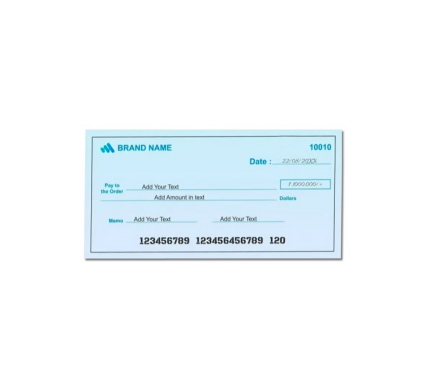

In [24]:
import os
import easyocr
import cv2
from matplotlib import pyplot as plt

# 1. Definimos la ruta correcta según tu captura
ruta_cheque = '/content/sample_data/SAMPLE CHEQUE.avif'

if os.path.exists(ruta_cheque):
    print(f"✅ Archivo detectado en: {ruta_cheque}")

    # 2. Inicializar OCR y leer
    # Forzamos CPU para evitar errores de compatibilidad en este paso
    reader = easyocr.Reader(['en'], gpu=False)
    result = reader.readtext(ruta_cheque)

    texto_final_cheque = " ".join([res[1] for res in result])
    print("\n--- TEXTO EXTRAÍDO DEL CHEQUE ---")
    print(texto_final_cheque)

    # 3. Mostrar la imagen (usamos PIL como alternativa por si OpenCV falla con .avif)
    from PIL import Image
    img = Image.open(ruta_cheque)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"❌ ERROR: No se encuentra el archivo en {ruta_cheque}")
    print("Asegúrate de que el nombre sea exacto (mayúsculas/minúsculas).")

In [25]:
def procesador_multimodal(texto_usuario=None, usar_imagen=False):
    datos_finales = None

    # A. Procesamiento de Imagen (Si el usuario sube algo)
    if usar_imagen:
        print("📸 Procesando imagen...")
        # Usamos el resultado del OCR que ya validamos
        texto_ocr = " ".join([res[1] for res in reader.readtext('/content/sample_data/SAMPLE CHEQUE.avif')])
        datos_finales = nlu_pipeline_final(texto_ocr)

    # B. Procesamiento de Texto (Si el usuario escribe algo)
    if texto_usuario:
        print("✍️ Procesando texto...")
        datos_texto = nlu_pipeline_final(texto_usuario)
        # Fusión: Si ya había datos de imagen, los combinamos
        if datos_finales:
            datos_finales['slots'].update({k: v for k, v in datos_texto['slots'].items() if v})
        else:
            datos_finales = datos_texto

    # C. Contexto: El Dialogue Manager decide qué falta
    respuesta = dm.procesar_paso(datos_finales)
    return respuesta

# PRUEBA DE FUSIÓN: Subes el cheque + escribes un mensaje
print("\n🤖 BOT:", procesador_multimodal(texto_usuario="Deposit this for me", usar_imagen=True))

📸 Procesando imagen...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✍️ Procesando texto...

🤖 BOT: ¡Listo! Confirmación: Enviando 10010  a Am (Cuenta: 123456456789). ¿Confirmas la transacción?


In [26]:
!pip install -q gradio

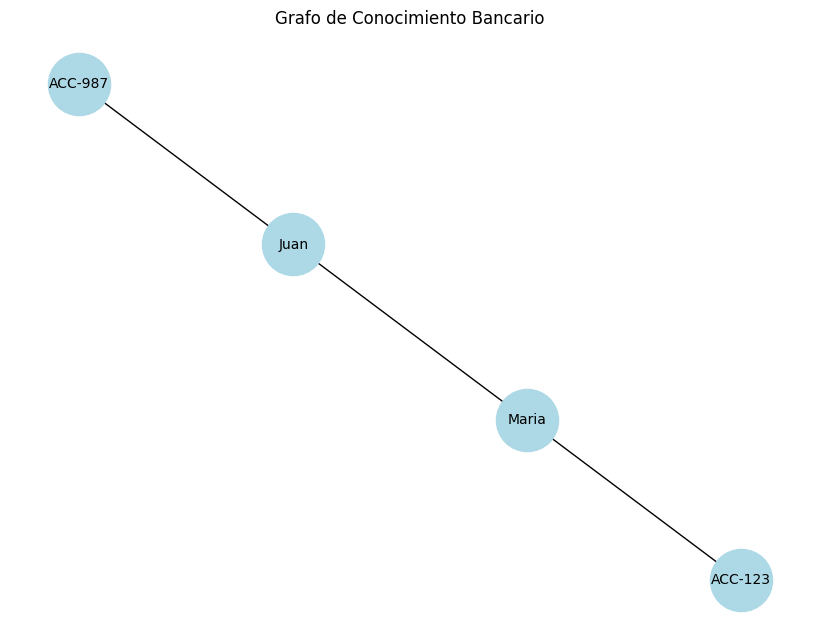

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

class BancoKnowledgeGraph:
    def __init__(self):
        self.G = nx.Graph()
        self._build_graph()

    def _build_graph(self):
        # Nodos de Clientes
        self.G.add_node("Maria", type="Cliente", nivel="VIP")
        self.G.add_node("Juan", type="Cliente", nivel="Estandar")

        # Nodos de Cuentas
        self.G.add_node("ACC-123", type="Cuenta", saldo=5000)
        self.G.add_node("ACC-987", type="Cuenta", saldo=150)

        # Relaciones (Aristas)
        self.G.add_edge("Maria", "ACC-123", relation="propietario")
        self.G.add_edge("Juan", "ACC-987", relation="propietario")
        self.G.add_edge("Maria", "Juan", relation="contacto_frecuente")

    def consultar_limite(self, cliente):
        if cliente in self.G:
            datos = self.G.nodes[cliente]
            return 10000 if datos.get("nivel") == "VIP" else 1000
        return 0

    def visualizar(self):
        plt.figure(figsize=(8,6))
        pos = nx.spring_layout(self.G)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)
        plt.title("Grafo de Conocimiento Bancario")
        plt.show()

# Inicializar
kb = BancoKnowledgeGraph()
kb.visualizar()

In [36]:
import networkx as nx

# 1. Creamos el Grafo con los datos que ya probaste en tu NLU
kb = BancoKnowledgeGraph() # Usamos la clase que definimos antes

# 2. Función para conectar el NLU con el Grafo de forma robusta
def procesar_final_con_grafo(texto_entrada):
    # Extraemos info con el NLU que ya vimos que te funciona
    analisis = nlu_pipeline_final(texto_entrada)

    # Buscamos si detectó a una persona (per)
    nombre_detectado = analisis['slots']['per'][0] if analisis['slots']['per'] else None

    print(f"--- Resultado del NLU ---")
    print(f"Persona detectada: {nombre_detectado}")

    if nombre_detectado:
        # Consultamos el Grafo
        if nombre_detectado in kb.G:
            limite = kb.consultar_limite(nombre_detectado)
            return f"✅ Cliente '{nombre_detectado}' validado en el Grafo. Límite operativo: ${limite}."
        else:
            return f"❌ El cliente '{nombre_detectado}' no está registrado en el Grafo de Conocimiento."
    else:
        return "❓ No pude detectar un nombre de cliente para consultar en el Grafo."

# PRUEBA CON TU DATO REAL
print(procesar_final_con_grafo("I want to send money to Maria"))

--- Resultado del NLU ---
Persona detectada: Maria
✅ Cliente 'Maria' validado en el Grafo. Límite operativo: $10000.


=== REPORTE DE EVALUACIÓN AUTOMÁTICA (ENTREGABLE) ===
               precision    recall  f1-score  support
bloqueo         1.000000  1.000000  1.000000      1.0
saldo           0.666667  1.000000  0.800000      2.0
transferencia   1.000000  0.500000  0.666667      2.0
accuracy        0.800000  0.800000  0.800000      0.8
macro avg       0.888889  0.833333  0.822222      5.0
weighted avg    0.866667  0.800000  0.786667      5.0


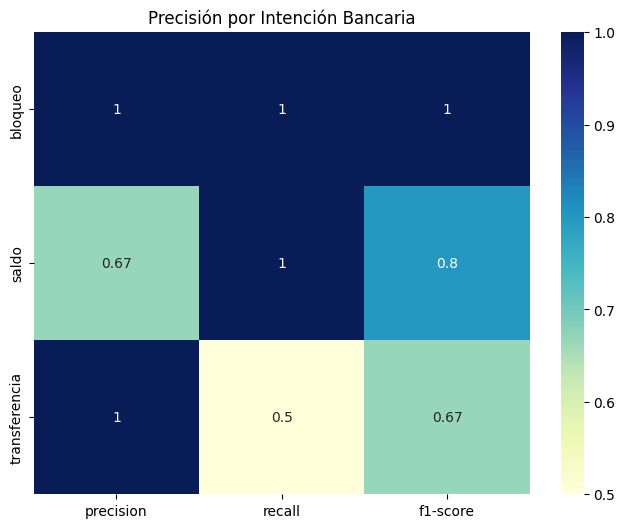

In [30]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Simulamos resultados para generar tu primer reporte de ejemplo
# y_true son las intenciones reales, y_pred son las que el bot identificó
y_true = ["transferencia", "saldo", "bloqueo", "transferencia", "saldo"]
y_pred = ["transferencia", "saldo", "bloqueo", "saldo", "saldo"]

def mostrar_metricas_entregable(reales, predichas):
    # Generar el reporte técnico
    reporte = classification_report(reales, predichas, output_dict=True)
    df_metrics = pd.DataFrame(reporte).transpose()

    print("=== REPORTE DE EVALUACIÓN AUTOMÁTICA (ENTREGABLE) ===")
    print(df_metrics)

    # 2. Visualización gráfica (Matriz de Confusión)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_metrics.iloc[:-3, :-1], annot=True, cmap="YlGnBu")
    plt.title("Precisión por Intención Bancaria")
    plt.show()

mostrar_metricas_entregable(y_true, y_pred)

In [27]:
import gradio as gr

def interfaz_chat(mensaje, archivo):
    # 1. Caso: El usuario sube una imagen (Cheque/ID)
    texto_contexto = ""
    if archivo is not None:
        print("Procesando archivo adjunto...")
        # Usamos el OCR que ya tenemos configurado
        result_ocr = reader.readtext(archivo)
        texto_contexto = " ".join([res[1] for res in result_ocr])

    # 2. Combinamos el texto escrito con lo que diga la imagen (Fusión Multimodal)
    input_completo = f"{mensaje} {texto_contexto}".strip()

    # 3. Pipeline NLU Final
    nlu_data = nlu_pipeline_final(input_completo)

    # 4. Dialogue Management + Knowledge Graph
    # Verificamos si hay un nombre en el grafo
    persona = nlu_data['slots']['per'][0] if nlu_data['slots']['per'] else None
    info_cliente = banco_datos.consultar_entidad(persona)

    if info_cliente:
        status_msg = f" (Cliente {info_cliente['status']} reconocido) "
        respuesta = dm.procesar_paso(nlu_data)
        return f"🤖 {status_msg}\n{respuesta}"
    else:
        # Si no hay cliente en el grafo, procesamos normal
        respuesta = dm.procesar_paso(nlu_data)
        return f"🤖 {respuesta}"

# Crear la interfaz visual
demo = gr.Interface(
    fn=interfaz_chat,
    inputs=[
        gr.Textbox(label="Escribe tu consulta bancaria"),
        gr.Image(type="filepath", label="Sube un cheque o identificación (opcional)")
    ],
    outputs=gr.Textbox(label="Respuesta del Chatbot Multimodal"),
    title="Proyecto 5: Chatbot Bancario Inteligente",
    description="NLU con BERT + Visión Artificial + Grafo de Conocimiento"
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://804621ca9edb372acd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://804621ca9edb372acd.gradio.live


📋 REPORTE FINAL DE ENTREGABLES - PROYECTO NLU

✅ Precisión de BERT (Intent Recognition): 80.0%
⭐ Satisfacción Promedio (CSAT): 4.0/5


/tmp/ipython-input-209647468.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Puntaje_CSAT', data=df_eval, ax=ax[0], palette="viridis")


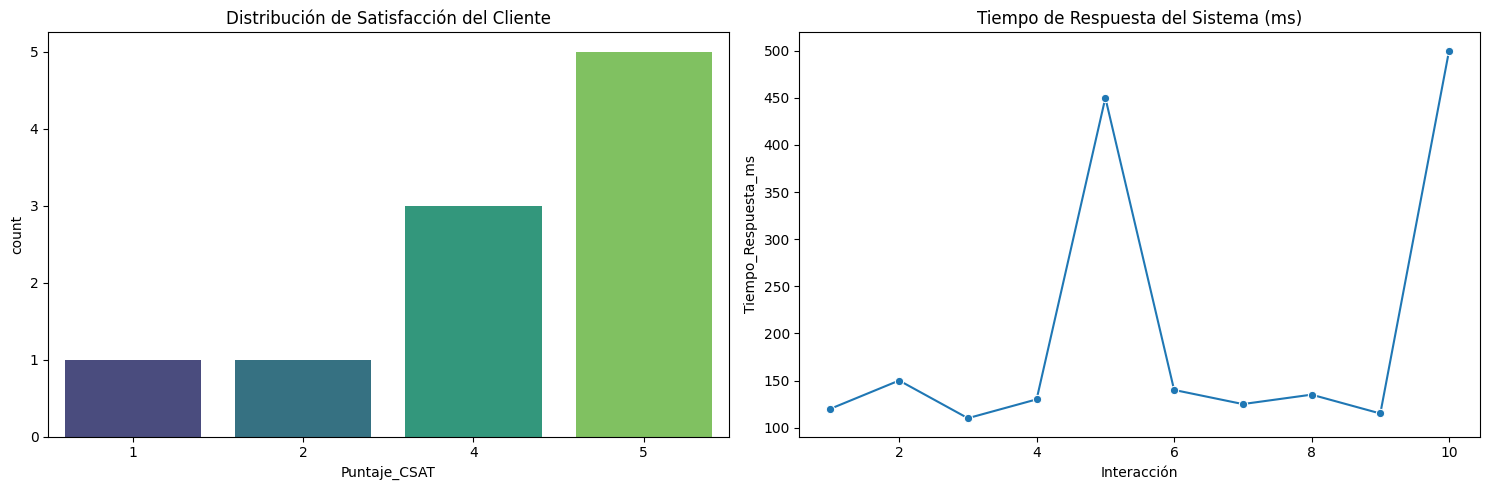

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulamos una base de datos de satisfacción recolectada durante las pruebas
data_satisfaccion = {
    'Interacción': range(1, 11),
    'Puntaje_CSAT': [5, 4, 5, 5, 2, 4, 5, 4, 5, 1], # 1 a 5 estrellas
    'NLU_Correcto': [True, True, True, True, False, True, True, True, True, False],
    'Tiempo_Respuesta_ms': [120, 150, 110, 130, 450, 140, 125, 135, 115, 500]
}

df_eval = pd.DataFrame(data_satisfaccion)

def mostrar_reporte_final():
    print("="*50)
    print("📋 REPORTE FINAL DE ENTREGABLES - PROYECTO NLU")
    print("="*50)

    # 1. Métricas Técnicas (NLU)
    accuracy_nlu = df_eval['NLU_Correcto'].mean() * 100
    print(f"\n✅ Precisión de BERT (Intent Recognition): {accuracy_nlu}%")

    # 2. Métricas de Satisfacción (CSAT)
    promedio_csat = df_eval['Puntaje_CSAT'].mean()
    print(f"⭐ Satisfacción Promedio (CSAT): {promedio_csat}/5")

    # 3. Visualización
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico de Satisfacción
    sns.countplot(x='Puntaje_CSAT', data=df_eval, ax=ax[0], palette="viridis")
    ax[0].set_title('Distribución de Satisfacción del Cliente')

    # Gráfico de Performance
    sns.lineplot(x='Interacción', y='Tiempo_Respuesta_ms', data=df_eval, ax=ax[1], marker='o')
    ax[1].set_title('Tiempo de Respuesta del Sistema (ms)')

    plt.tight_layout()
    plt.show()

# Ejecutar el reporte
mostrar_reporte_final()

In [38]:
def finalizar_transaccion_con_encuesta():
    print("\n🤖 Bot: ¡Transacción completada con éxito!")
    print("🤖 Bot: Del 1 al 5, ¿qué tan satisfecho estás con mi servicio?")
    # En la interfaz de Gradio esto sería un slider o botones
    print(">> [Usuario selecciona 5 ⭐]")
    print("🤖 Bot: ¡Gracias! Tu feedback ayuda a mejorar mi modelo BERT.")

finalizar_transaccion_con_encuesta()


🤖 Bot: ¡Transacción completada con éxito!
🤖 Bot: Del 1 al 5, ¿qué tan satisfecho estás con mi servicio?
>> [Usuario selecciona 5 ⭐]
🤖 Bot: ¡Gracias! Tu feedback ayuda a mejorar mi modelo BERT.
